# Gram-schmidt and the KF

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
%config InlineBackend.figure_format = "retina"

## The best linear unbiased predictor for a signal plus noise model

$$
    {\bf A}_\text{opt} = \arg\min_{\bf A}\| f_t - {\bf A}\,y_{1:t} \|_2^2
$$

In [5]:
def ssm(key, signal_init, n_steps, qt, rt):
    def ssm_step(signal_prev, key):
        key_measurement, key_state = jax.random.split(key)
        ut = jax.random.normal(key_state) * qt
        et = jax.random.normal(key_measurement) * rt

        signal = signal_prev + ut
        measurement = signal + et

        return signal, (signal, measurement)

    keys = jax.random.split(key, n_steps)
    _, (signals, measurements) = jax.lax.scan(ssm_step, signal_init, keys)
    return signals, measurements

In [6]:
key = jax.random.PRNGKey(314)

In [13]:
signal_init = 0.0
n_steps = 100
qt = 0.05
rt = 0.1
signals, measurements = ssm(key, signal_init, n_steps, qt, rt)

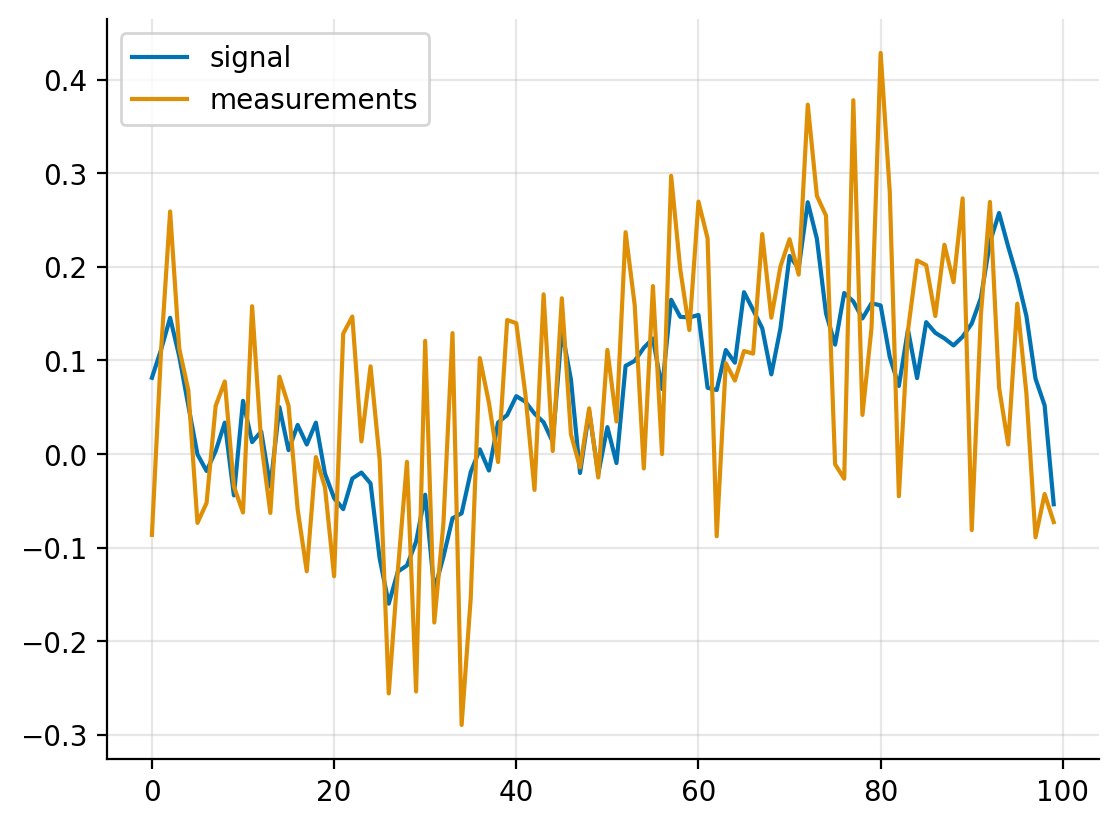

In [14]:
plt.plot(signals, label="signal")
plt.plot(measurements, label="measurements")
plt.legend()
plt.grid(alpha=0.3)

In [104]:
vssm = jax.vmap(ssm, in_axes=(0, None, None, None, None), out_axes=-1)

In [257]:
n_trials = 500
keys = jax.random.split(key, n_trials)

In [271]:
n_steps = 100
signal_init = 0.0
rt = 0.1
qt = 0.05

signals, measurements = vssm(keys, signal_init, n_steps, qt, rt)

In [272]:
signals.shape

(100, 500)

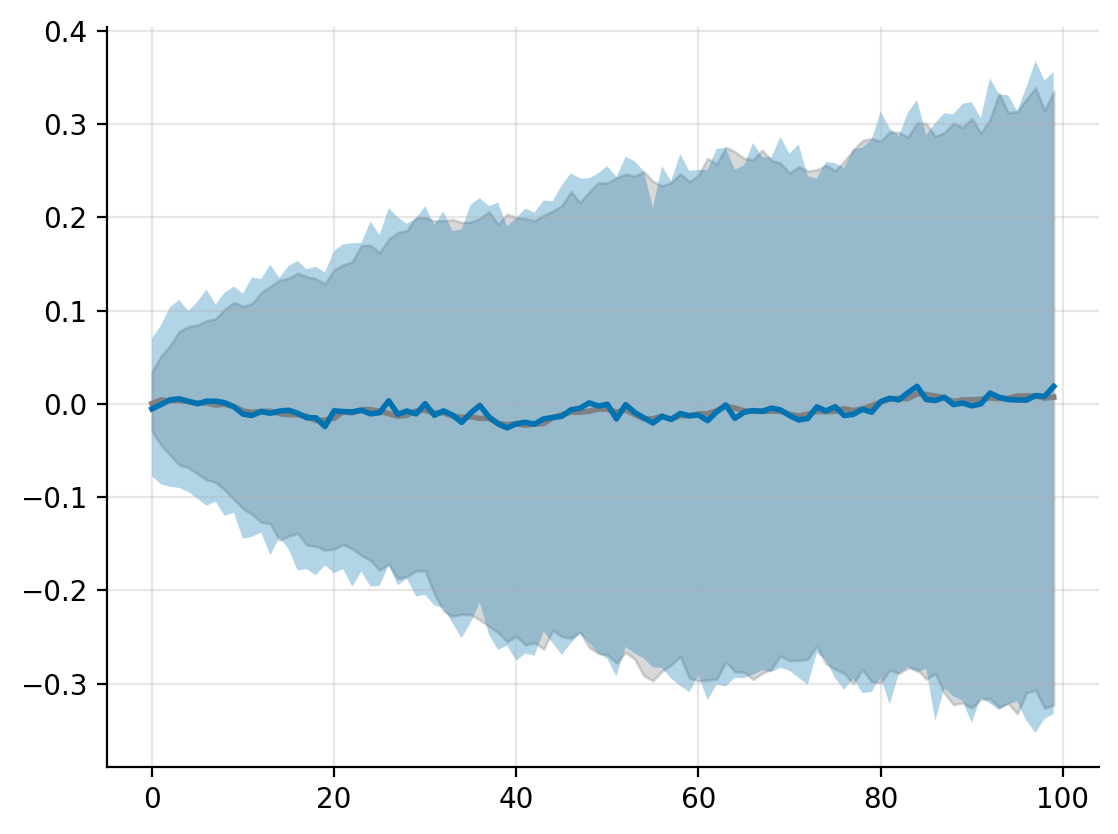

In [273]:
xrange = jnp.arange(n_steps)

smid = signals.mean(axis=1)
shigh = jnp.quantile(signals, 0.75, axis=1)
sslow = jnp.quantile(signals, 0.25, axis=1)

plt.fill_between(xrange, shigh, sslow, color="gray", alpha=0.3)
plt.plot(xrange, smid, c="gray", linewidth=2)

# plt.plot(signals.T)
plt.grid(alpha=0.3)

xrange = jnp.arange(n_steps)

smid = measurements.mean(axis=1)
shigh = jnp.quantile(measurements, 0.75, axis=1)
sslow = jnp.quantile(measurements, 0.25, axis=1)

plt.fill_between(xrange, shigh, sslow, alpha=0.3)
plt.plot(xrange, smid, linewidth=2)

# plt.plot(signals.T)
plt.grid(alpha=0.3)

In [274]:
measurements.shape

(100, 500)

In [275]:
signals.shape

(100, 500)

In [276]:
C = jnp.r_[signals[-1, :][None, :], measurements]
C = jnp.cov(C)
C.shape

(101, 101)

In [293]:
var_f = C[0, 0]
cov_fy = C[0, 1:] # Cov(ft, y[1:t])
var_y = C[1:, 1:] # var(yt)

In [278]:
cov_fy.shape

(100,)

In [279]:
var_y.shape

(100, 100)

In [280]:
cov_fy @ jnp.linalg.inv(var_y) @ measurements[:, 0]

Array(-0.44108826, dtype=float32)

In [281]:
A = jnp.einsum("i,ij->j", cov_fy, jnp.linalg.inv(var_y))
blup = A @ measurements[:, 0]
blup

Array(-0.44108826, dtype=float32)

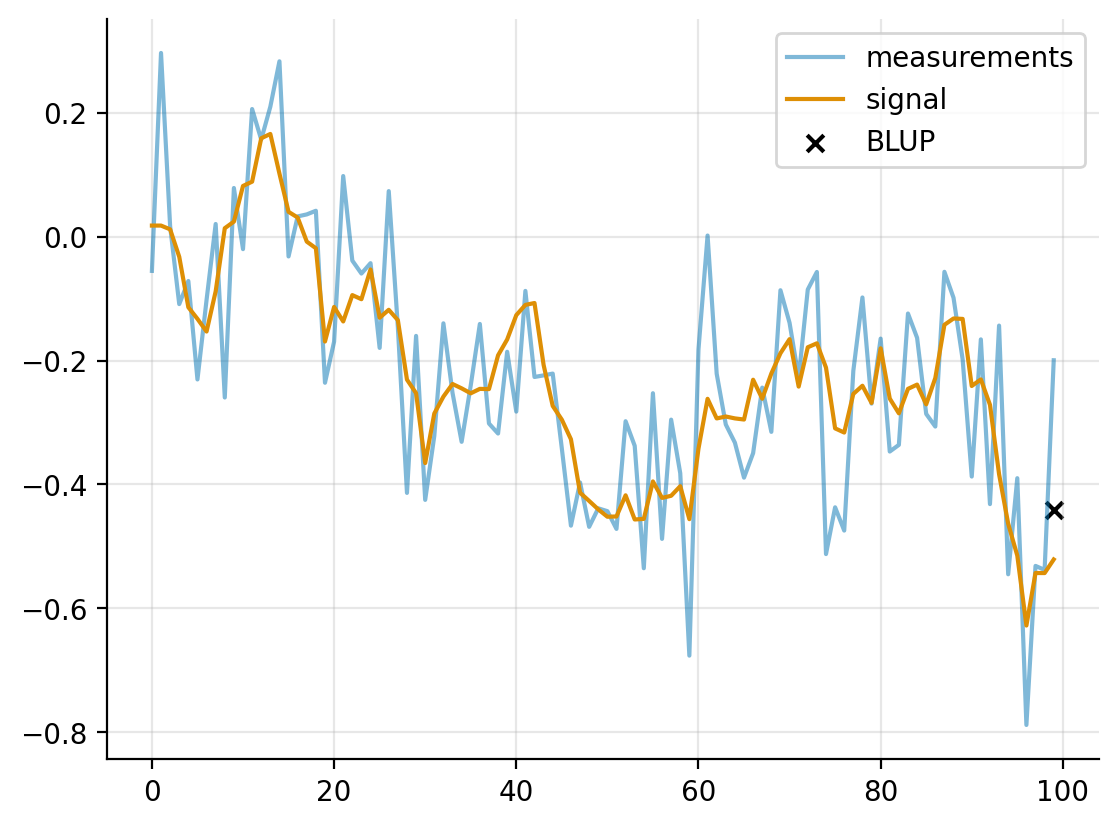

In [288]:
plt.plot(xrange, measurements[:, 0], label="measurements", alpha=0.5)
plt.plot(xrange, signals[:, 0], label="signal")
plt.scatter(xrange[-1], blup, label="BLUP", c="black", marker="x")
plt.legend()
plt.grid(alpha=0.3)

In [297]:
s = jnp.sqrt(var_f - A @ var_y @ A.T)

In [298]:
s # plot error-stdev estimate

Array(0.05607666, dtype=float32)